### Loading dataset, Scaling data points and splitting data
###### Replicating the study (DOI: 10.1109/ACCESS.2023.3280122), where only 6 features were used

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("CICIDS2017_Wednesday_Paper.csv")
df.columns=df.columns.str.strip()

#using the selected features
selectedFeatures=['Destination Port', 'Total Length of Bwd Packets','Bwd Packet Length Std', 'Flow IAT Mean', 'Bwd Packets/s','Packet Length Mean', 'Label']
df=df[selectedFeatures]

#Remove Heartbleed records as the study did.
df.drop(df[df["Label"]=="Heartbleed"].index,inplace=True)
df["Label"].replace(["BENIGN","DoS Hulk","DoS GoldenEye","DoS slowloris","DoS Slowhttptest"],[0,1,2,3,4],inplace=True)

X = MinMaxScaler().fit_transform(df.drop(['Label'],axis=1))
y=df["Label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

C:\Users\dyari\AppData\Local\Temp\ipykernel_13272\3817712183.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Label"].replace(["BENIGN","DoS Hulk","DoS GoldenEye","DoS slowloris","DoS Slowhttptest"],[0,1,2,3,4],inplace=True)
C:\Users\dyari\AppData\Local\Temp\ipykernel_13272\3817712183.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_o

### Training the MLP model

In [8]:
from sklearn.neural_network import MLPClassifier
import time

clf = MLPClassifier(hidden_layer_sizes=(100,200,250),
                    max_iter=50,solver="adam",
                    verbose=True,activation='relu',
                    learning_rate_init=0.01,random_state=42)

start_time = time.time()
# Fit data onto the model
clf.fit(X_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time

Iteration 1, loss = 0.11035642
Iteration 2, loss = 0.07369259
Iteration 3, loss = 0.06933552
Iteration 4, loss = 0.06357330
Iteration 5, loss = 0.06013228
Iteration 6, loss = 0.05732809
Iteration 7, loss = 0.05778670
Iteration 8, loss = 0.05296763
Iteration 9, loss = 0.05056275
Iteration 10, loss = 0.04624085
Iteration 11, loss = 0.04310545
Iteration 12, loss = 0.04283733
Iteration 13, loss = 0.04059827
Iteration 14, loss = 0.03920460
Iteration 15, loss = 0.04254337
Iteration 16, loss = 0.03795726
Iteration 17, loss = 0.03840178
Iteration 18, loss = 0.03873008
Iteration 19, loss = 0.03955279
Iteration 20, loss = 0.04120229
Iteration 21, loss = 0.04108642
Iteration 22, loss = 0.04053955
Iteration 23, loss = 0.03767524
Iteration 24, loss = 0.04212794
Iteration 25, loss = 0.04424086
Iteration 26, loss = 0.03918364
Iteration 27, loss = 0.03779170
Iteration 28, loss = 0.03809647
Iteration 29, loss = 0.03798092
Iteration 30, loss = 0.03866082
Iteration 31, loss = 0.03877733
Iteration 32, los

### Predictions BEFORE sample modification

Accuracy: 0.9893964876316417
---------------------------------------------------------


array([[86822,   780,    34,   202,    37],
       [   49, 46163,    52,     5,    11],
       [   64,    72,  1902,     0,    19],
       [   78,    18,     9,  1094,     5],
       [   31,     0,     1,     2,  1089]], dtype=int64)

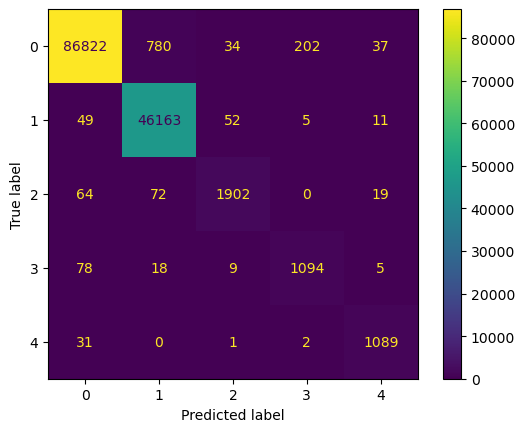

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("---------------------------------------------------------")

BeforePerturbation = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
BeforePerturbation.confusion_matrix

### Sample modification 01 - Malicious Shuffle

In [12]:
import random

#Identify the unique 'Flow IAT Mean' values of non-benign classes
non_benign_data = df[df['Label'] != 0]  # Filter out benign (label == 0)
unique_non_benign_values = non_benign_data['Flow IAT Mean'].unique()

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        if y.iloc[idx] != 0:  # If it's non-benign (use iloc for position-based access)
            # Replace 'Flow IAT Mean' with a random value from the unique non-benign values
            X_copy.loc[idx, feature] = random.choice(unique_non_benign_values)

    return X_copy, y_copy


X_evasive1, y_evasive1 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')


### Predictions After sample modification 01 - Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.9606969878517962
---------------------------------------------------------


array([[86822,   780,    34,   202,    37],
       [    0, 46272,     8,     0,     0],
       [    0,  2057,     0,     0,     0],
       [    0,  1204,     0,     0,     0],
       [    0,  1123,     0,     0,     0]], dtype=int64)

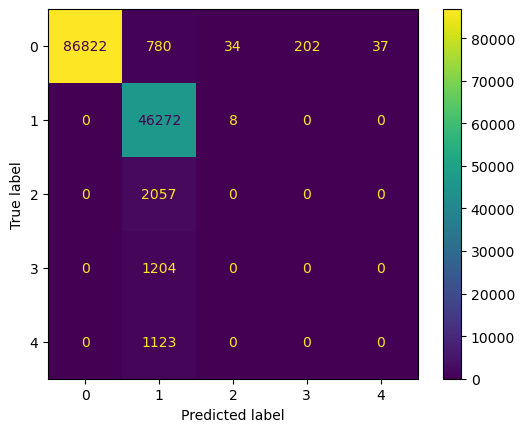

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred1_evasive = clf.predict(X_evasive1)
print("Accuracy:", accuracy_score(y_evasive1,y_pred1_evasive))
print("---------------------------------------------------------")

Perturb01 = ConfusionMatrixDisplay.from_predictions(y_evasive1,y_pred1_evasive)
Perturb01.confusion_matrix

### Sample modification 02 - Benign Shuffle

In [16]:
import random

#Identify the unique 'Flow IAT Mean' values of benign class
benign_data = df[df['Label'] == 0]  # Filter in benign only (label == 0)
unique_benign_values = benign_data['Flow IAT Mean'].unique()

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)
    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        if y.iloc[idx] == 0:  # If it's benign (use iloc for position-based access)
            # Replace 'Flow IAT Mean' with a random value from the unique benign values
            X_copy.loc[idx, feature] = random.choice(unique_benign_values)

    return X_copy, y_copy

X_evasive2, y_evasive2 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification 02 - Benign Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.36357993056106946
---------------------------------------------------------


array([[  122, 87640,    36,     0,    77],
       [   49, 46163,    52,     5,    11],
       [   64,    72,  1902,     0,    19],
       [   78,    18,     9,  1094,     5],
       [   31,     0,     1,     2,  1089]], dtype=int64)

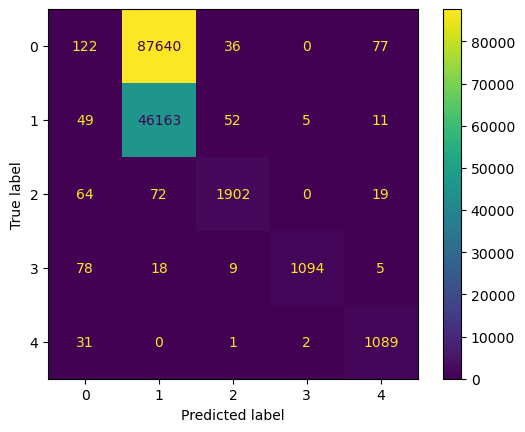

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred2_evasive = clf.predict(X_evasive2)

print("Accuracy:", accuracy_score(y_evasive2,y_pred2_evasive))
print("---------------------------------------------------------")


Perturb02=ConfusionMatrixDisplay.from_predictions(y_evasive2, y_pred2_evasive)
Perturb02.confusion_matrix

### Sample modification 03 - Both Benign and Malicious Shuffle

In [20]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy


X_evasive3, y_evasive3 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Sample modification 03 - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.3346350125235493
---------------------------------------------------------


array([[  100, 87680,    22,     0,    73],
       [    0, 46260,    20,     0,     0],
       [    0,  2057,     0,     0,     0],
       [    0,  1204,     0,     0,     0],
       [    0,  1123,     0,     0,     0]], dtype=int64)

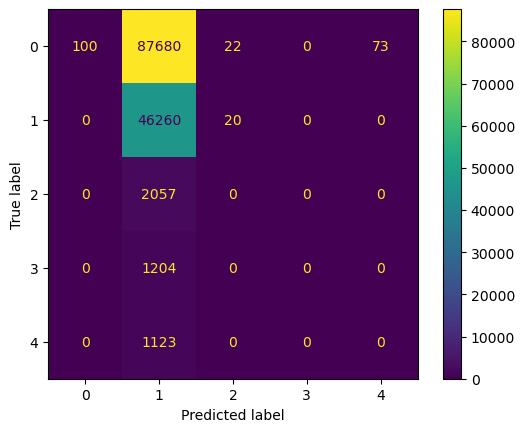

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred3_evasive = clf.predict(X_evasive3)

print("Accuracy:", accuracy_score(y_evasive3,y_pred3_evasive))
print("---------------------------------------------------------")


Perturb03=ConfusionMatrixDisplay.from_predictions(y_evasive3, y_pred3_evasive)
Perturb03.confusion_matrix